# Multivariate Stock Price Prediction - LSTM

## PHASE 1 : Exploratory Data Analysis

### Loading necessary libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
from tensorflow.keras.models import load_model

### Loading the dataset

In [ ]:
# Data file location and Loading the dataset
data_file_location = "..\\data\\raw\\"
data_file_name = "google_stock_price_full"
data_file_ext = "csv"

# Load data file
data = pd.read_csv(data_file_location + data_file_name + "." + data_file_ext)

In [ ]:
#sample
data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2891,2016-02-12,34.513000,34.687500,33.930000,34.119999,34.119999,42828000
3122,2017-01-12,40.356998,40.369499,39.958500,40.318001,40.318001,27062000
4280,2021-08-19,135.467499,137.451996,135.356003,136.913498,136.913498,18296000
930,2008-04-30,14.002764,14.566900,13.909613,14.303636,14.303636,317304895
4169,2021-03-12,104.250000,104.513000,102.377502,103.096001,103.096001,34516000


In [ ]:
# Shape of the dataset
print("Number of rows:",data.shape[0])
print("Number of columns:",data.shape[1])

Number of rows: 4940
Number of columns: 7


In [ ]:
# Data types

In [ ]:
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

## Data cleaning

In [ ]:
# Convert Date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

In [ ]:
# Check column format
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

### Dataset exploration

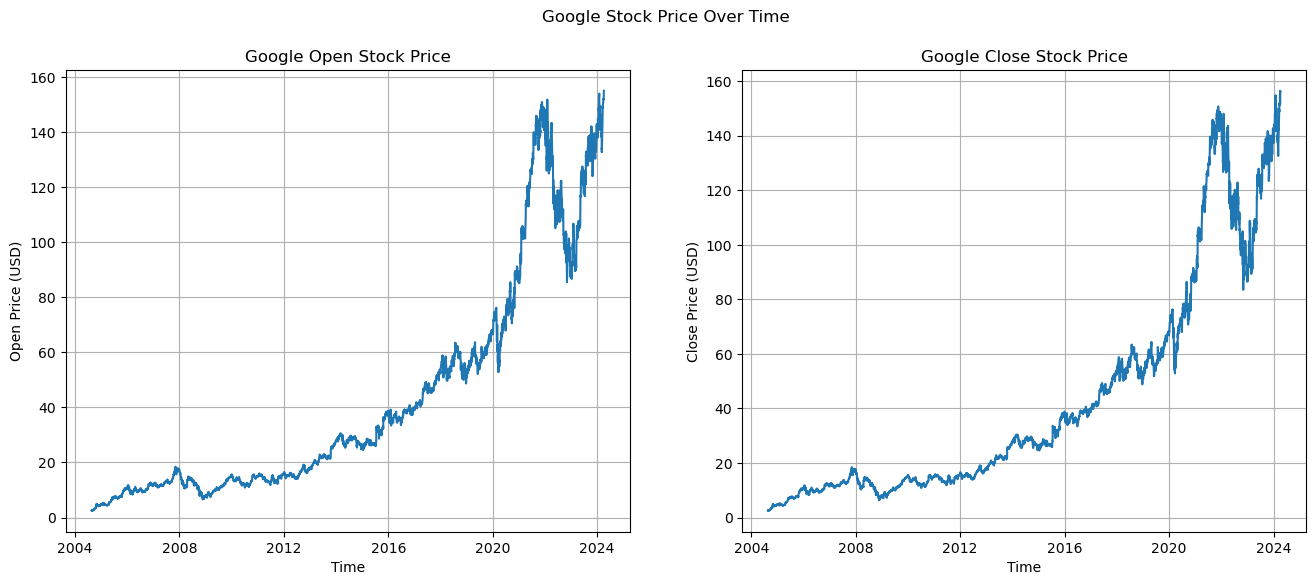

In [ ]:
# Plot of Open and Close price for the whole period
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(data["Date"], data["Open"])
plt.xlabel("Time")
plt.ylabel("Open Price (USD)")
plt.title("Google Open Stock Price")
plt.grid()

plt.subplot(1,2,2)
plt.plot(data["Date"], data["Close"])
plt.xlabel("Time")
plt.ylabel("Close Price (USD)")
plt.title("Google Close Stock Price")
plt.grid()

plt.suptitle("Google Stock Price Over Time")
plt.show()

The previous charts show an inconsistent behavior in the stock's performance over time, with a completely distinct trend during the past five years.

This means that the old historical data might not be relevant to the predictions, since it's most likely to represents a different period with outdated indicators that don't affect the current trend.

Accordingly, we will concentrate our analysis on the most recent five-year data, as it is expected to provide more accurate insights for predicting future trends.

In [ ]:
# Select stock price records for the last five years, starting from 2019
data_5years = data[data["Date"].dt.year >= 2019]

# Filtered data shape
data_5years.shape

(1323, 7)

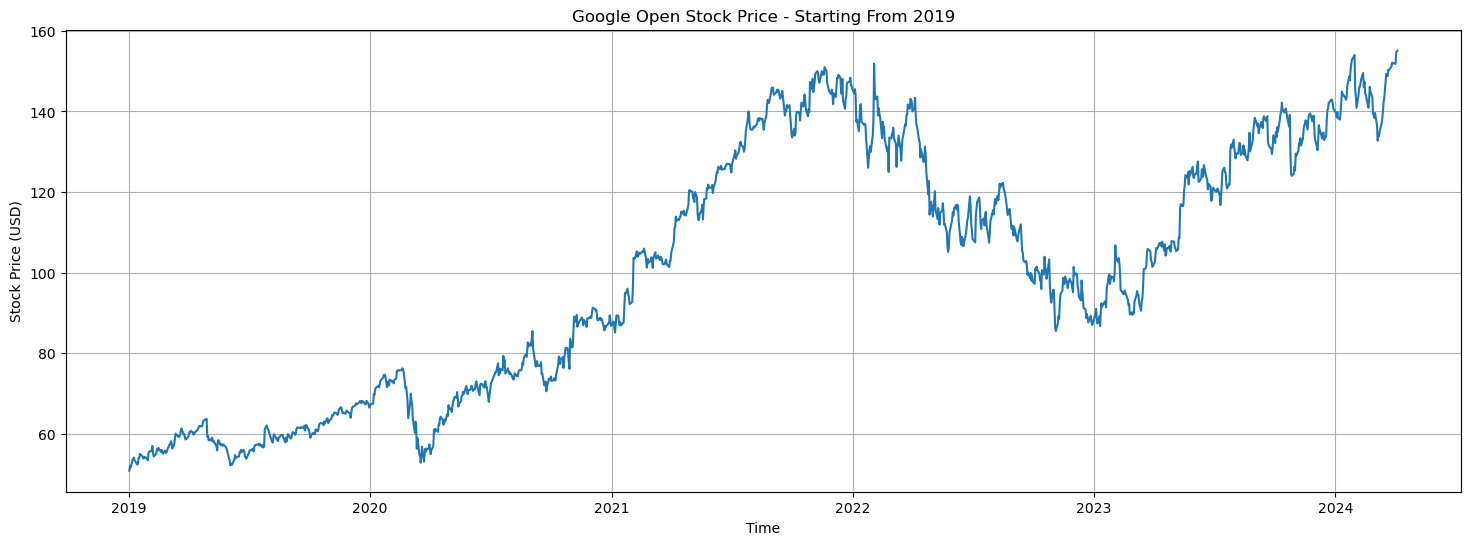

In [ ]:
# Plot for Open stock price performance in the last five years
plt.figure(figsize=(18,6))
plt.plot(data_5years["Date"], data_5years["Open"])
plt.xlabel("Time")
plt.ylabel("Stock Price (USD)")
plt.title("Google Open Stock Price - Starting From 2019")
plt.grid()

### Filtering the dataset

In [ ]:
# Preparing data file location
data_file_location = "..//data//interim//"
data_file_name = "google_stock_price_recent"
data_file_ext = "csv"

# Storing dataset
data_5years.to_csv(data_file_location + data_file_name + "." + data_file_ext, index=None)

## PHASE 2 : Data Preprocessing

### Loading necessary libraries

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import matplotlib.dates as mdates

In [ ]:
# Set output width
pd.set_option("display.width", 120)

### Loading the dataset

In [ ]:
# Prepare data file location and name
data_file_location = "..//data//interim//"
data_file_name = "google_stock_price_recent"
data_file_ext = "csv"

# Load data file
data = pd.read_csv(data_file_location + data_file_name + "." + data_file_ext)

In [ ]:
# Check loaded data shape
data.shape

(1323, 7)

In [ ]:
# Check loaded data head
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,50.828499,52.616001,50.785500,52.292500,52.292500,30652000
1,2019-01-03,52.049999,52.848999,50.703499,50.803001,50.803001,36822000
2,2019-01-04,51.629501,53.542000,51.370899,53.535500,53.535500,41878000
3,2019-01-07,53.575001,53.700001,52.737999,53.419498,53.419498,39638000
4,2019-01-08,53.805500,54.228001,53.026501,53.813999,53.813999,35298000


In [ ]:
# Check columns types
data.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

### Data preprocessing

In [ ]:
# Convertig date column to a valid Datetime format
data["Date"] = pd.to_datetime(data["Date"])

# Check column types
data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

#### Select Independent Features
The objective of this analysis is to implement a multi-variant prediction, taking into account possible impact of several independent features such as the Open price, Close price and Volume on future stock price performance.

Therefore, in this analysis, we will incorporate all the available variables:

- Opening price
- Highest price
- Lowest price
- Closing price
- Adjusted closing price
- Trading volume

These features will be utilized to forecast the future opening price.

In [ ]:
# Defining selected features and target attribute
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
target = "Open"

#### Creating Train, Validation, and Test Datasets
To monitor and assess the performance of our model, we will partition the recent stock price dataset into three segments: training, validation, and testing sets.

The division will be structured as follows:

- **Training dataset:** covering the period from the start of 2019 till June, 2023.
- **Validation dataset:** representing the stock prices from July, 2023 till the end of 2023.
- **Testing dataset:** representing the stock prices for the first two months of 2024.

In [ ]:
# Defining start and end time for each period
train_end_date = pd.to_datetime("2023-06-30")
validate_start_date = pd.to_datetime("2023-07-01")
validate_end_date = pd.to_datetime("2023-12-31")
test_start_date = pd.to_datetime("2024-01-01")
test_end_date = pd.to_datetime("2024-02-29")

# Splitting dataset into training, validation, and testing
data_train = data[data["Date"] <= train_end_date][features]
data_train_dates = data[data["Date"] <= train_end_date]["Date"]
data_validate = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)][features]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)][features]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

In [ ]:
# Shape of each dataset
print(f"Training Set: {data_train.shape}")
print(f"Validation Set: {data_validate.shape}")
print(f"Testing Set: {data_test.shape}")

Training Set: (1132, 6)
Validation Set: (126, 6)
Testing Set: (41, 6)


In [ ]:
# Summary of each dataset
print("Training Dataset:")
print(data_train.head())
print("Validation Dataset:")
print(data_validate.head())
print("Testing Dataset:")
print(data_test.head())

Training Dataset:
        Open       High        Low      Close  Adj Close    Volume
0  50.828499  52.616001  50.785500  52.292500  52.292500  30652000
1  52.049999  52.848999  50.703499  50.803001  50.803001  36822000
2  51.629501  53.542000  51.370899  53.535500  53.535500  41878000
3  53.575001  53.700001  52.737999  53.419498  53.419498  39638000
4  53.805500  54.228001  53.026501  53.813999  53.813999  35298000
Validation Dataset:
            Open        High         Low       Close   Adj Close    Volume
1132  120.320000  121.019997  119.705002  120.559998  120.559998  13888300
1133  120.059998  123.370003  120.059998  122.629997  122.629997  17830300
1134  120.639999  121.150002  119.250000  120.930000  120.930000  17732500
1135  120.889999  121.750000  120.089996  120.139999  120.139999  20982400
1136  119.070000  119.070000  116.639999  116.870003  116.870003  32960100
Testing Dataset:
            Open        High         Low       Close   Adj Close    Volume
1258  139.600006  

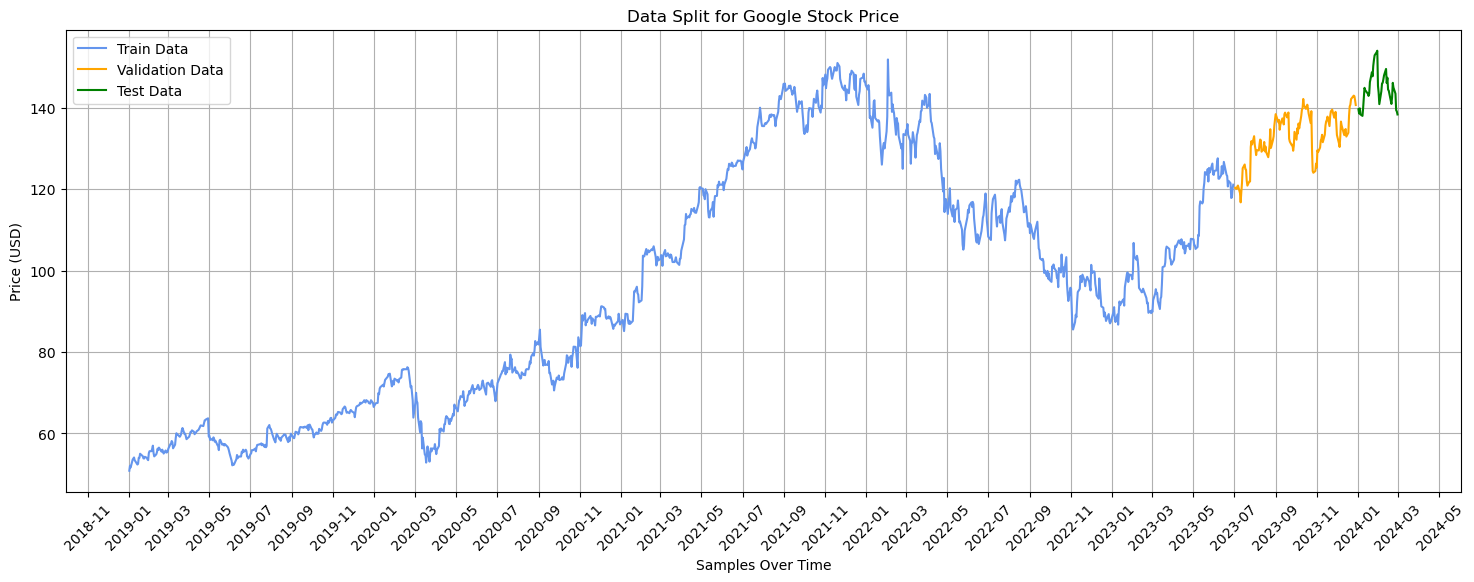

In [ ]:
# Plot stock prices for each data split
plt.figure(figsize=(18,6))
plt.plot(data_train_dates, data_train["Open"], color="cornflowerblue")
plt.plot(data_validate_dates, data_validate["Open"], color="orange")
plt.plot(data_test_dates, data_test["Open"], color="green")
plt.legend(["Train Data", "Validation Data", "Test Data"])
plt.title("Data Split for Google Stock Price")
plt.xlabel("Samples Over Time")
plt.ylabel("Price (USD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()

### Data Scaling

In [ ]:
# Check the distribution of input features
data[features].describe()

,Open,High,Low,Close,Adj Close,Volume
count,1323.000000,1323.000000,1323.000000,1323.000000,1323.000000,1.323000e+03
mean,100.882880,102.042442,99.853834,100.974635,100.974635,2.882756e+07
std,31.078299,31.360869,30.780336,31.059813,31.059813,1.268332e+07
min,50.828499,52.374500,50.676800,50.803001,50.803001,6.936000e+06
25%,71.211247,71.905250,70.356251,70.992001,70.992001,2.076335e+07
50%,102.825996,103.927498,101.500000,102.751503,102.751503,2.575600e+07
75%,130.778503,132.021675,129.389999,130.440002,130.440002,3.287305e+07
max,155.080002,157.000000,154.132004,156.500000,156.500000,1.241400e+08


Looking at these details, it's noticeable and anticipated that all price values exhibit similar distributions given they log the price fluctuation on daily basis.

Conversely, the trading volume presents a distinct distribution that differs significantly.

Accordingly, input features need to be transformed into a unified scale and since the distribution doesn't indicate any outliers, we will use the [0,1] range to normalize all features.

To prevent data leakage, we will fit the scaler solely to the training data. Subsequently, we will use this fitted scaler to transform the training, validation, and testing datasets.

In [ ]:
# Initialize scaler with range [0,1]
sc = MinMaxScaler(feature_range=(0,1))

# Fit and transform scaler to training set
data_train_scaled = sc.fit_transform(data_train)

# Transform validating and testing datasets
data_validate_scaled = sc.transform(data_validate)
data_test_scaled = sc.transform(data_test)

The scaler employed here will also be utilized in subsequent phases to revert the scaled data back to its original distribution. Therefore, it is essential to save this scaler to a local folder for future use.

In [ ]:
# Prepare scaler model name and location
scaler_model_location = "..//models//"
scaler_model_name = "google_stock_price_scaler"
scaler_model_ext = "gz"

# Store scaler model
joblib.dump(sc, scaler_model_location + scaler_model_name + "." + scaler_model_ext)

['..//models//google_stock_price_scaler.gz']

### Storing processed dataset

The training, validation, and testing datasets have been processed and are prepared for training the LSTM model in the next phase.

Prior to saving these datasets, it is necessary to reassemble the dates corresponding to each dataset. This will facilitate later evaluation of the model's performance.

In [ ]:
# Combine dates with each corresponding dataset
data_train_scaled_final = pd.DataFrame(data_train_scaled, columns=features, index=None)
data_train_scaled_final["Date"] = data_train_dates.values

data_validate_scaled_final = pd.DataFrame(data_validate_scaled, columns=features, index=None)
data_validate_scaled_final["Date"] = data_validate_dates.values

data_test_scaled_final = pd.DataFrame(data_test_scaled, columns=features, index=None)
data_test_scaled_final["Date"] = data_test_dates.values

In [ ]:
# Prepare datasets files and location
data_file_location = "..//data//processed//"
data_file_name_train = "google_stock_price_processed_train"
data_file_name_validate = "google_stock_price_processed_validate"
data_file_name_test = "google_stock_price_processed_test"
data_file_ext = "csv"

# Store datasets
data_train_scaled_final.to_csv(data_file_location + data_file_name_train + "." + data_file_ext, index=None)
data_validate_scaled_final.to_csv(data_file_location + data_file_name_validate + "." + data_file_ext, index=None)
data_test_scaled_final.to_csv(data_file_location + data_file_name_test + "." + data_file_ext, index=None)

## Phase 3 : Model Building

In [ ]:
# Review the code and add appropriate commands (Karthik Ram - skr)

In [ ]:
# Import necessary libraries and modules
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
import joblib
import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [ ]:
# Prepare data file location and name
data_file_location = "..//data//processed//"
data_file_name_train = "google_stock_price_processed_train"
data_file_name_validate = "google_stock_price_processed_validate"
data_file_name_test = "google_stock_price_processed_test"
data_file_ext = "csv"

# Load data files
data_train_df = pd.read_csv(data_file_location + data_file_name_train + "." + data_file_ext)
data_validate_df = pd.read_csv(data_file_location + data_file_name_validate + "." + data_file_ext)
data_test_df = pd.read_csv(data_file_location + data_file_name_test + "." + data_file_ext)

In [ ]:
# Check loaded datasets shape
print(f"Training Dataset Shape: {data_train_df.shape}")
print(f"Validation Dataset Shape: {data_validate_df.shape}")
print(f"Testing Dataset Shape: {data_test_df.shape}")

Training Dataset Shape: (1132, 7)
Validation Dataset Shape: (126, 7)
Testing Dataset Shape: (41, 7)


In [ ]:
# Display a summary of each dataset
print("Training Dataset:")
print(data_train_df.head())
print("Validation Dataset:")
print(data_validate_df.head())
print("Testing Dataset:")
print(data_test_df.head())

Training Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.000000  0.002422  0.001096  0.014909   0.014909  0.202348  2019-01-02
1  0.012090  0.004758  0.000269  0.000000   0.000000  0.254991  2019-01-03
2  0.007928  0.011707  0.006996  0.027351   0.027351  0.298130  2019-01-04
3  0.027184  0.013291  0.020776  0.026190   0.026190  0.279018  2019-01-07
4  0.029465  0.018586  0.023684  0.030138   0.030138  0.241988  2019-01-08
Validation Dataset:
       Open      High       Low     Close  Adj Close    Volume        Date
0  0.687796  0.688344  0.695774  0.698226   0.698226  0.059318  2023-07-03
1  0.685223  0.711909  0.699352  0.718946   0.718946  0.092952  2023-07-05
2  0.690964  0.689648  0.691188  0.701930   0.701930  0.092117  2023-07-06
3  0.693438  0.695665  0.699654  0.694022   0.694022  0.119846  2023-07-07
4  0.675424  0.668791  0.664880  0.661292   0.661292  0.222041  2023-07-10
Testing Dataset:
       Open      High       Low     Close  Ad

In [ ]:
# Convert Date column to a valid Datetime format
data_train_df["Date"] = pd.to_datetime(data_train_df["Date"])
data_validate_df["Date"] = pd.to_datetime(data_validate_df["Date"])
data_test_df["Date"] = pd.to_datetime(data_test_df["Date"])

In [ ]:
# Extract dates from each dataset
data_train_dates = data_train_df["Date"]
data_validate_dates = data_validate_df["Date"]
data_test_dates = data_test_df["Date"]

In [ ]:
# Extract features
features = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
data_train_scaled = data_train_df[features].values
data_validate_scaled = data_validate_df[features].values
data_test_scaled = data_test_df[features].values

Given that we are addressing a time series problem involving multiple predictors, our task involves constructing and reshaping the input data to suit the LSTM model.

This entails setting a sliding time window (sequence size) that determines the number of past observations used to predict the subsequent value.

In this experiment, we employ a sequence of previous samples (financial days) of all variables to forecast the opening price on the following day.

In [ ]:
# Define a method to construct the input data X and Y
def construct_lstm_data(data, sequence_size, target_attr_idx):
    """
    Construct input data (X) and target data (y) for LSTM model from a pandas DataFrame.

    Parameters:
    -----------
    data : numpy.ndarray
        Input data array of shape (n_samples, n_features).

    sequence_size : int
        Number of previous time steps to use as input features for predicting the next time step.

    target_attr_idx : int
        Index of column in `data` DataFrame that corresponds to target attribute that LSTM model will predict.

    Returns:
    --------
    data_X : numpy.ndarray
        Array of LSTM input sequences of shape (n_samples - sequence_size, sequence_size, n_features).

    data_y : numpy.ndarray
        Corresponding target values for each input sequence of shape (n_samples - sequence_size,).
    """

    # Initialize constructed data variables
    data_X = []
    data_y = []

    # Iterate over the dataset
    for i in range(sequence_size, len(data)):
        data_X.append(data[i-sequence_size:i,0:data.shape[1]])
        data_y.append(data[i,target_attr_idx])

    # Return constructed variables
    return np.array(data_X), np.array(data_y)

The construction function is currently available for constructing subsets for training, validation, and testing date that is aligned with the LSTM model input.

In [ ]:
#Define the sequence size
sequence_size = 60

# Construct training data
X_train, y_train = construct_lstm_data(data_train_scaled, sequence_size, 0)

Because creating input data requires observations from previous samples, constructing subsets for the validation and testing periods suggests we append data from previous periods.

For instance, to predict the initial stock price in the validation period, we must combine recent actual stock prices (sequence) from the training period. This step is crucial for providing the LSTM model with the expected sequence.

Same principle applies to stock performance during the testing phase but in this case (and depending on the sequence size), we may need to combine samples from both validation and testing subsets.

To facilitate this step, we combine the whole scaled dataset together and then select corresponding chunks before constructing the input data sets.

In [ ]:
# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

# Construct validation dataset
X_validate, y_validate = construct_lstm_data(data_all_scaled[train_size-sequence_size:train_size+validate_size,:], sequence_size, 0)

# Construct testing dataset
X_test, y_test = construct_lstm_data(data_all_scaled[-(test_size+sequence_size):,:], sequence_size, 0)

In [ ]:
# Check original data and data splits shapes
print(f"Full Scaled Data: {data_all_scaled.shape}")
print(f"\n Data Train Scaled: {data_train_scaled.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate_scaled.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test_scaled.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")

Full Scaled Data: (1299, 6)

 Data Train Scaled: (1132, 6)
> Data Train X: (1072, 60, 6)
> Data Train y: (1072,)

 Data Validate Scaled: (126, 6)
> Data Validate X: (126, 60, 6)
> Data Validate y: (126,)

 Data Test Scaled: (41, 6)
> Data Test X: (41, 60, 6)
> Data Test y: (41,)


### Training the lstm model

#### Building the model

In [ ]:
# Initializing the model
regressor = Sequential()

In [ ]:
# Add input layer
regressor.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

In [ ]:
# Add first LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add second LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add third LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add forth LSTM layer and dropout regularization layer
regressor.add(LSTM(units = 100))
regressor.add(Dropout(rate = 0.2))

In [ ]:
# Add last dense layer/output layer
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the model
regressor.compile(optimizer = "adam", loss="mean_squared_error")

#### Training Model

In [ ]:
# Create a checkpoint to monitor the validation loss and save the model with the best performance.
model_location = "..//models//"
model_name = "google_stock_price_lstm.model.keras"
best_model_checkpoint_callback = ModelCheckpoint(
    model_location + model_name,
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=0)

In [ ]:
# Training the model
history = regressor.fit(
    x = X_train,
    y = y_train,
    validation_data=(X_validate, y_validate),
    epochs=200,
    batch_size = 64,
    callbacks = [best_model_checkpoint_callback])

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - loss: 0.0887 - val_loss: 0.0261
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0077 - val_loss: 0.0024
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.0052 - val_loss: 0.0027
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - loss: 0.0044 - val_loss: 0.0031
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 9/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 10/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 11/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 12/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 2

#### Performance Evaluation

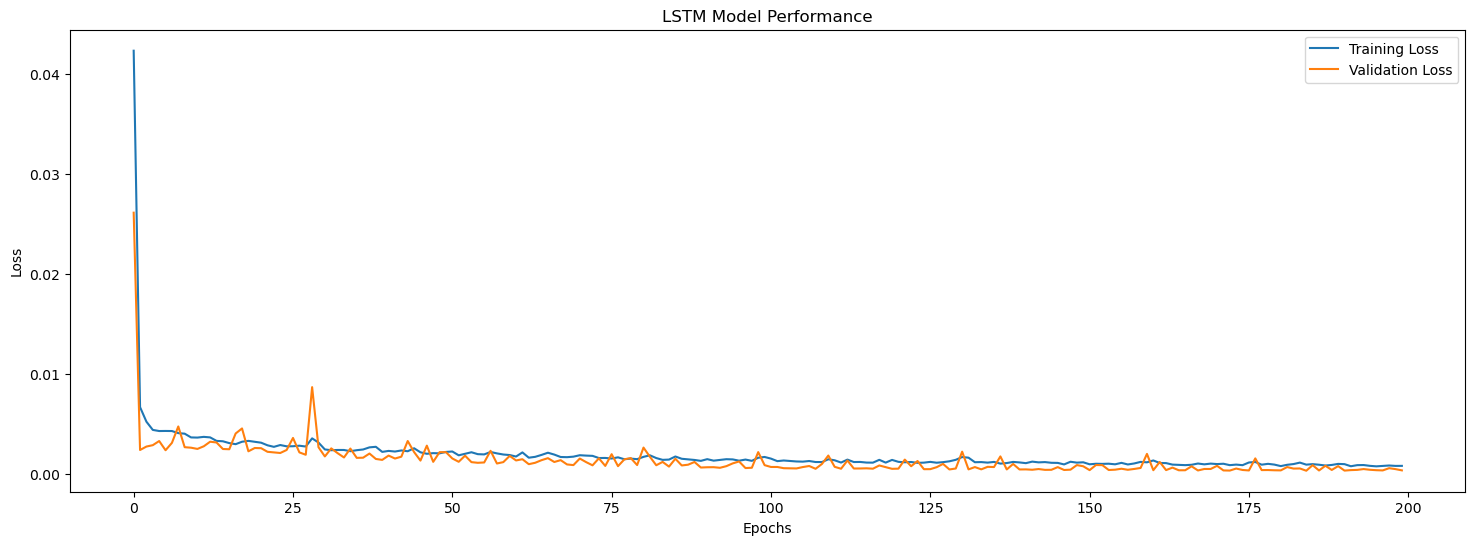

In [ ]:
# Visualizing model performance during training
plt.figure(figsize=(18, 6))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")

plt.title("LSTM Model Performance")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


The chart above highlights the following observations:

- Training loss values decrease over the epochs, starting from a higher value and gradually decreasing. This indicates that the model is learning to fit the training data better as training progresses.
- Similarly, the validation loss values also decrease initially, indicating improvement in the model's ability to generalize to unseen data (validation set).
- Some fluctuations in the validation loss have been observed, which is quite justifiable due to the high variations and complexity in the price performance over time.
- There are no signs of overfitting since both loss values are continuously decreasing along with each other over the epochs.
- Validation loss has maintained lower values than training loss across almost the whole training period, which is quite normal due to the complexity/size of training data.

## Model Explainability (with SHAP (SHapley Additive exPlanations))

In [ ]:
regressor.save("lstm_stock_model.h5")  # Save the trained model
model = load_model("lstm_stock_model.h5")  # Reload the model for SHAP

In [ ]:
# Select 100 samples as background data
background_data = X_train[:100]

# Select 10 samples to analyze model predictions
test_samples = X_test[:10]

### SHAP Explainer

In [ ]:
explainer = shap.GradientExplainer(model, background_data)

### Computing the SHAP Values

In [ ]:
# Reshape 3D LSTM input into 2D format for SHAP visualization
test_samples_2d = test_samples.reshape(test_samples.shape[0], -1)

In [ ]:
shap_values_2d = np.array(shap_values).reshape(test_samples.shape[0], -1)

### Feature Importance

In [ ]:
original_feature_names = data_train_df.columns

C:\Users\msaak\AppData\Local\Temp\ipykernel_21472\3637776920.py:12: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values_2d, test_samples_2d, feature_names=feature_names)


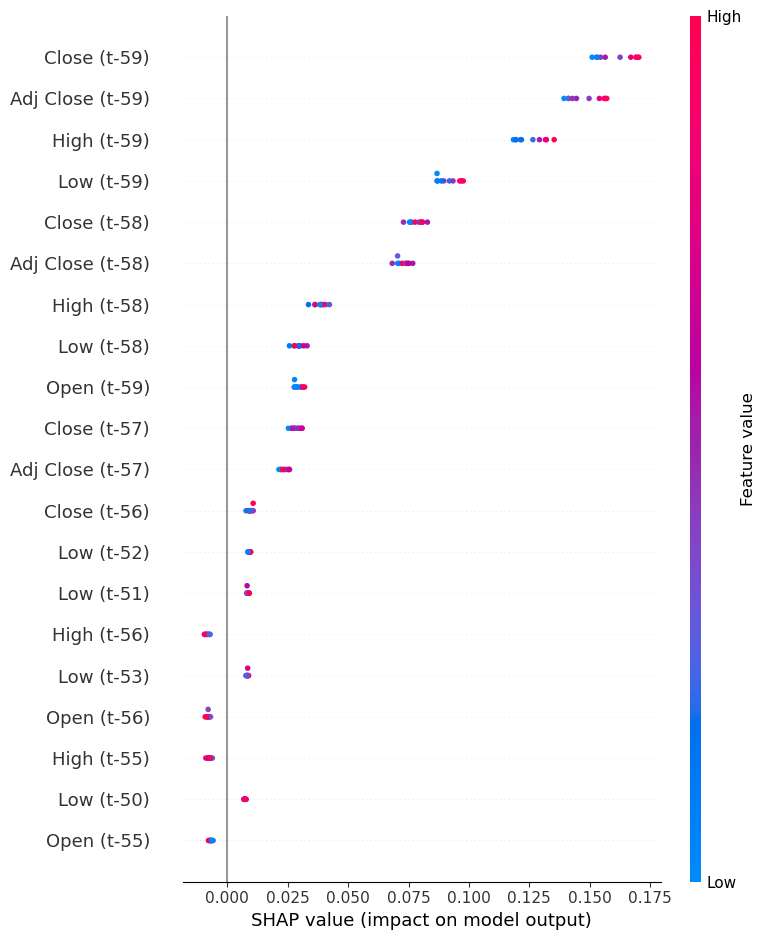

In [ ]:
time_steps = X_train.shape[1]   # 50
num_features = X_train.shape[2]  # 7

# Generate feature names in (time_step, feature) format
feature_names = [
    f"{original_feature_names[f]} (t-{t})"
    for t in range(time_steps)
    for f in range(num_features)
]

# Use this for SHAP visualization
shap.summary_plot(shap_values_2d, test_samples_2d, feature_names=feature_names)


## PHASE 4 : MODEL INFERENCE

In [ ]:
## Start with Model Inference and prediction (Aniketha P - AP)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

# Load the trained LSTM model
model_path = "lstm_stock_model.h5"
model = load_model(model_path)

# Display Model Summary
print("\n LSTM Model Summary:\n")
model.summary()


 LSTM Model Summary:



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,103 (1.08 MB)

 Trainable params: 284,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

**Model Inference & Prediction**

For time series forecasting, the model requires sequential input data. The script prepares test data by creating sequences of 60-time steps, meaning each prediction is based on the past 60 days of stock price movements. A sliding window approach is used to generate overlapping sequences from the dataset. The target variable, which is the "Open" price at each prediction step, is also stored in a separate array. Finally, the input data is reshaped to match the expected input format of the LSTM model: a three-dimensional array consisting of samples, time steps, and features.With the prepared test data, the LSTM model is used to make predictions. Since the predictions are in a scaled format (due to MinMaxScaler), they must be inverse-transformed to obtain real stock prices. To accomplish this, a dummy array with the same shape as the original dataset is created, with only the first column (representing the "Open" price) filled with the model’s predictions. The inverse transformation is then applied to restore the actual price values. This step ensures that the predictions can be directly compared with the real-world stock prices.

In [11]:
# Load the stock price dataset
data_file = "C:\\Users\\msaak\\NNDL_Project\\data\\raw\\google_stock_price_full.csv"
df = pd.read_csv(data_file)

# Define the same feature columns used in training
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
target = "Open"  # The model predicts the "Open" price

# Scale the input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features].values)

# Prepare input data for inference (use last 60 timesteps)
look_back = 60
X_test, y_actual = [], []
for i in range(len(scaled_data) - look_back):
    X_test.append(scaled_data[i:i + look_back])
    y_actual.append(scaled_data[i + look_back, 0])  # True 'Open' price in scaled form

X_test = np.array(X_test)
y_actual = np.array(y_actual)

# Ensure correct shape for inference
X_test = np.reshape(X_test, (X_test.shape[0], look_back, len(features)))

# Perform inference
predicted_scaled = model.predict(X_test)

# Inverse transform only the "Open" price predictions
dummy_array = np.zeros((predicted_scaled.shape[0], len(features)))  # Create a dummy array
dummy_array[:, 0] = predicted_scaled[:, 0]  # Fill the first column (Open)
predicted_stock_price = scaler.inverse_transform(dummy_array)[:, 0]  # Extract only the "Open" column

# Inverse transform actual values
dummy_actual = np.zeros((y_actual.shape[0], len(features)))
dummy_actual[:, 0] = y_actual
actual_stock_price = scaler.inverse_transform(dummy_actual)[:, 0]

153/153 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step


**Storing data for PowerBI visualization**

In [21]:
# Ensure the dataset has a Date column
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    dates = df['Date'].values[look_back:]
else:
    dates = np.arange(len(actual_stock_price))  # Use indices if no Date column exists

# Create DataFrame for Power BI
forecast_df = pd.DataFrame({
    'Date': dates,
    'Actual_Open_Price': actual_stock_price,
    'Predicted_Open_Price': predicted_stock_price
})

# Save to CSV
forecast_csv_path = "C:\\Users\\msaak\\NNDL_Project\\data\\processed\\stock_forecast.csv"
forecast_df.to_csv(forecast_csv_path, index=False)
print(f"Forecast CSV saved at: {forecast_csv_path}")


Forecast CSV saved at: C:\Users\msaak\NNDL_Project\data\processed\stock_forecast.csv


**Model Performance Evaluation**

To measure the accuracy of the predictions, three key evaluation metrics are calculated:

Mean Absolute Error (MAE): Measures the average absolute difference between actual and predicted stock prices, providing an intuitive understanding of the model’s error.

Root Mean Squared Error (RMSE): Penalizes larger errors more than MAE, making it useful for identifying significant deviations in predictions.

Mean Absolute Percentage Error (MAPE): Expresses the error as a percentage of the actual values, allowing for easier interpretation across different price ranges.

In [22]:
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
rmse = np.sqrt(mean_squared_error(actual_stock_price, predicted_stock_price))
mape = np.mean(np.abs((actual_stock_price - predicted_stock_price) / actual_stock_price)) * 100

print(f"\n Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error)    : {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAPE (Mean Absolute % Error)  : {mape:.2f}%")


 Model Evaluation Metrics:
MAE  (Mean Absolute Error)    : 0.8055
RMSE (Root Mean Squared Error): 1.2090
MAPE (Mean Absolute % Error)  : 2.27%


**Visualization of Predictions**

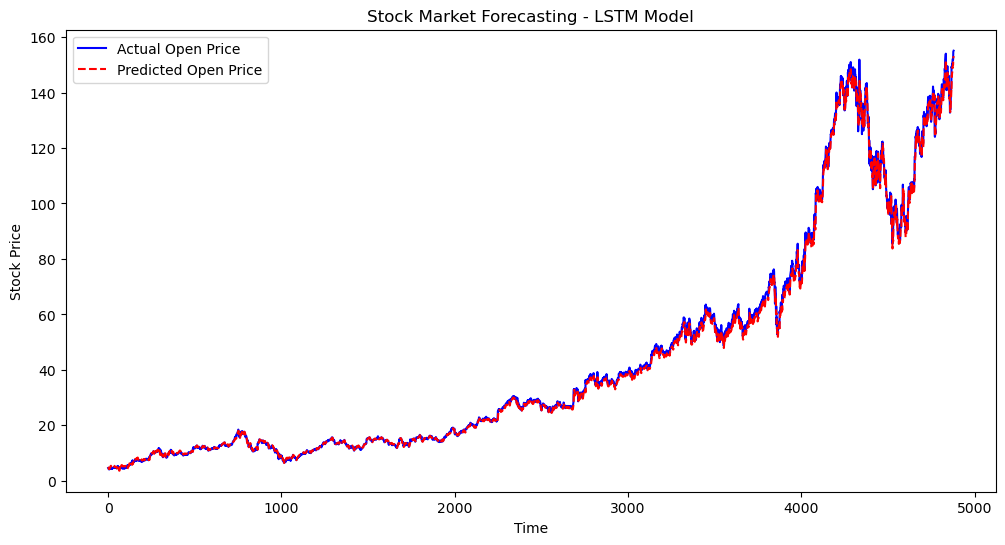

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(actual_stock_price, label="Actual Open Price", color='blue')
plt.plot(predicted_stock_price, label="Predicted Open Price", linestyle="dashed", color='red')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Market Forecasting - LSTM Model")
plt.show()

**Uncertainty Estimation & Confidence Interval**

Since stock market forecasting involves uncertainty, the script approximates confidence intervals for the predictions. By calculating the standard deviation of the prediction errors, a 95% confidence interval is estimated using the formula:

 Upper Bound = Prediction + (1.96 × Standard Deviation) <br>Lower Bound = Prediction − (1.96 × Standard Deviation)<br>
These confidence intervals provide an estimate of the range within which future stock prices are likely to fall. The plot includes shaded regions representing these intervals, allowing analysts to visualize the level of certainty in the model’s predictions.

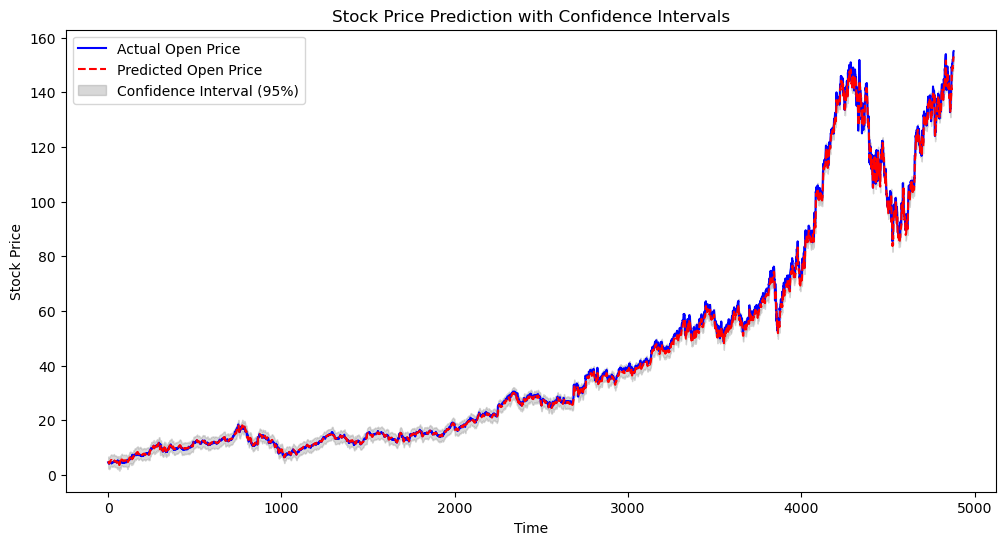

In [24]:
error = actual_stock_price - predicted_stock_price
std_dev = np.std(error)
upper_bound = predicted_stock_price + (1.96 * std_dev)
lower_bound = predicted_stock_price - (1.96 * std_dev)

plt.figure(figsize=(12, 6))
plt.plot(actual_stock_price, label="Actual Open Price", color='blue')
plt.plot(predicted_stock_price, label="Predicted Open Price", linestyle="dashed", color='red')
plt.fill_between(range(len(predicted_stock_price)), lower_bound, upper_bound, color='gray', alpha=0.3, label="Confidence Interval (95%)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price Prediction with Confidence Intervals")
plt.show()

In [25]:
from numpy import mean

naive_forecast = actual_stock_price[:-1]  # Simple shift as naive forecast
naive_error = mean(np.abs(actual_stock_price[1:] - naive_forecast))
mase = mae / naive_error
print(f"MASE (Mean Absolute Scaled Error): {mase:.4f}")


MASE (Mean Absolute Scaled Error): 1.4381


In [26]:
smape = np.mean(2 * np.abs(actual_stock_price - predicted_stock_price) /
               (np.abs(actual_stock_price) + np.abs(predicted_stock_price))) * 100
print(f"SMAPE (Symmetric MAPE): {smape:.2f}%")


SMAPE (Symmetric MAPE): 2.27%


In [27]:
from sklearn.metrics import r2_score

r2 = r2_score(actual_stock_price, predicted_stock_price)
print(f"R² Score: {r2:.4f}")


R² Score: 0.9991


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


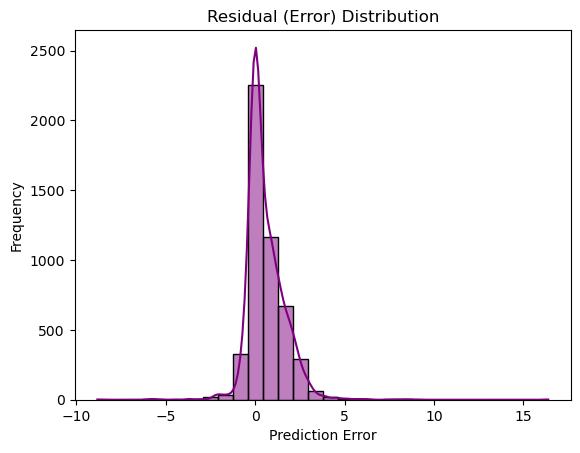

In [28]:
residuals = actual_stock_price - predicted_stock_price
sns.histplot(residuals, kde=True, bins=30, color='purple')
plt.title("Residual (Error) Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()


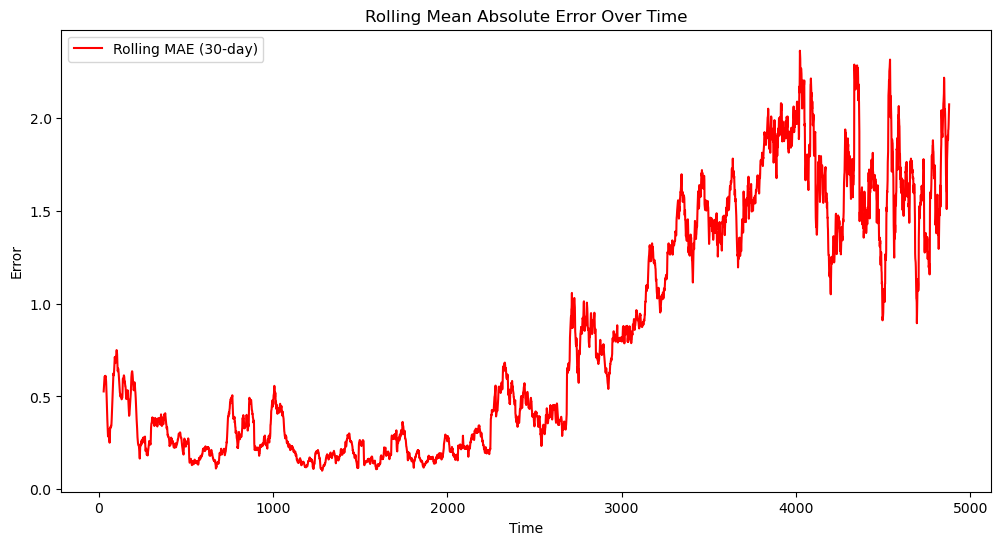

In [29]:
rolling_mae = pd.Series(np.abs(residuals)).rolling(window=30).mean()
plt.figure(figsize=(12, 6))
plt.plot(rolling_mae, label="Rolling MAE (30-day)", color='red')
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Rolling Mean Absolute Error Over Time")
plt.legend()
plt.show()


# PHASE 5 : TENSORBOARD